# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План исследования:**
 * Загрузка и подготовка данных.
 * Обучение и проверка модели.
 * Подготовка к расчёту прибыли.
 * Расчёт прибыли и рисков. 
 * Вывод.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

* `/datasets/geo_data_0.csv`   
* `/datasets/geo_data_1.csv`   
* `/datasets/geo_data_2.csv` 

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей), **целевой признак**.

## Загрузка и подготовка данных

#### Загрузка данных

In [1]:
RANDOM_STATE = 43
TEST_SIZE = 0.25

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
try:
    geo_0 = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/7 спринт/geo_data_0.csv')
    geo_1 = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/7 спринт/geo_data_1.csv')
    geo_2 = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/7 спринт/geo_data_2.csv')
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
    
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

display(geo_0.head(5))
display(geo_1.head(5))
display(geo_2.head(5))

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Выведем информацию о датафреймах, изучим типы данных и количество столбцов.

In [4]:
geo_0.info()
geo_1.info()
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Данные оформлены корректно, типы данных соответсвуют содержимому и пропуски не обнаружены. Проверим на наличие явных дубликатов.

#### Работа с дубликатами

In [5]:
print(f'Количество выявленных явных дубликатов в данных о первом регионе: {geo_0.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в данных о втором регионе: {geo_1.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в данных о третьем регионе: {geo_2.duplicated().sum()}')

Количество выявленных явных дубликатов в данных о первом регионе: 0
Количество выявленных явных дубликатов в данных о втором регионе: 0
Количество выявленных явных дубликатов в данных о третьем регионе: 0


Проверим столбец `id` каждого датафрейма на наличие неявных дубликатов.

In [6]:
print(f"Количество дубликатов в уникальных идентификаторов скважин 1: {geo_0['id'].nunique()}")
print(f"Количество дубликатов в уникальных идентификаторов скважин 2: {geo_1['id'].nunique()}")
print(f"Количество дубликатов в уникальных идентификаторов скважин 3: {geo_2['id'].nunique()}")

Количество дубликатов в уникальных идентификаторов скважин 1: 99990
Количество дубликатов в уникальных идентификаторов скважин 2: 99996
Количество дубликатов в уникальных идентификаторов скважин 3: 99996


По описанию данных столбец с уникальными идентификаторами скважин должен содержать оригинальные значения. Посмотрим на дубликаты.

In [7]:
dupli_0 = geo_0['id'][geo_0['id'].duplicated()].unique()
display(geo_0[geo_0['id'].isin(dupli_0)])

dupli_1 = geo_1['id'][geo_1['id'].duplicated()].unique()
display(geo_1[geo_1['id'].isin(dupli_1)])

dupli_2 = geo_2['id'][geo_2['id'].duplicated()].unique()
display(geo_2[geo_2['id'].isin(dupli_2)])

,id,f0,f1,f2,product
931,HZww2,0.76,0.37,1.86,30.68
1364,bxg6G,0.41,0.86,-3.65,73.60
1949,QcMuo,0.51,-0.32,-2.22,75.50
3389,A5aEY,-0.04,0.16,0.21,89.25
7530,HZww2,1.06,-0.37,10.43,158.83
16633,fiKDv,0.16,1.03,5.59,95.82
21426,Tdehs,0.83,0.30,-0.05,96.04
41724,bxg6G,-0.82,0.55,3.63,93.01
42529,AGS9W,1.45,-0.48,0.68,126.37
51970,A5aEY,-0.18,0.94,-2.09,33.02


,id,f0,f1,f2,product
1305,LHZR0,11.17,-1.95,3.00,80.86
2721,bfPNe,-9.49,-5.46,4.01,110.99
5849,5ltQ6,-3.44,-12.30,2.00,57.09
41906,LHZR0,-8.99,-4.29,2.01,57.09
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82178,bfPNe,-6.20,-4.82,3.00,84.04
82873,wt4Uk,10.26,-9.38,4.99,134.77
84461,5ltQ6,18.21,2.19,3.99,107.81


,id,f0,f1,f2,product
11449,VF7Jo,2.12,-0.86,5.75,181.72
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39
44378,Vcm5J,-1.23,-2.44,1.22,137.97
45404,KUPhW,0.23,-1.70,4.99,11.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
55967,KUPhW,1.21,3.18,5.54,132.83
95090,Vcm5J,2.59,1.99,2.48,92.33


Идентификаторы дублируются, но данные о признаках точек разные. Думаю, что ошибка носит технический характер, оставим дубликаты, так как все равно будем удалять столбец `id` и нам важна оригинальность только в столбцах с характеристиками скважин.   

Исследуем признаки.

#### Исследовательский анализ

In [8]:
def quantitative_features(df, attribute, title, bins=20):
    """
    Plots for quantitative attributes without target segmentation
    Parameters:
        df: DataFrame
        attribute: Column with the quantitative attribute
        title: Title of graphs
        bins: Number of bins for the histogram
            
    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], color="cornflowerblue")
    ax[0].set_title('Гистограмма', fontsize=18)
    ax[0].set_xlabel(title, fontsize=15)
    
    sns.boxplot(x=attribute, data=df, ax=ax[1], color="cornflowerblue")
    ax[1].set_title('Ящик с усами', fontsize=18)
    ax[1].set_xlabel(title, fontsize=15)

    sns.set(rc={'figure.figsize': (10, 7.5),
                'axes.labelsize': 12,  
                'xtick.labelsize': 10, 
                'ytick.labelsize': 10,
                })
    
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(df[attribute].describe().T)

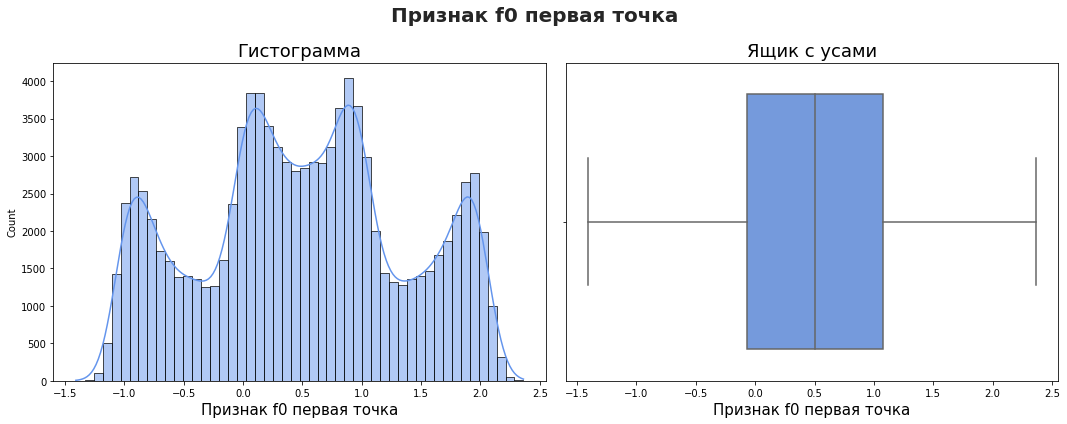

count   100000.00
mean         0.50
std          0.87
min         -1.41
25%         -0.07
50%          0.50
75%          1.07
max          2.36
Name: f0, dtype: float64


In [9]:
quantitative_features(geo_0, 'f0', 'Признак f0 первая точка', bins=50)

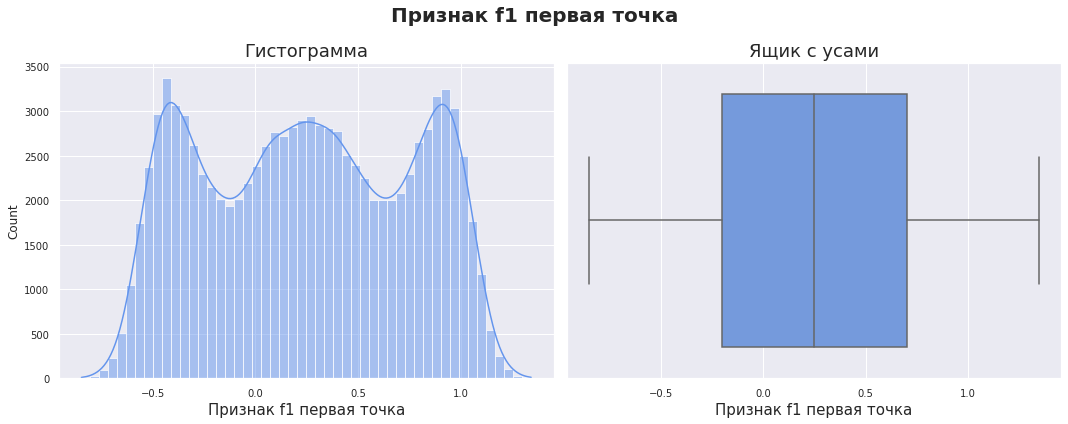

count   100000.00
mean         0.25
std          0.50
min         -0.85
25%         -0.20
50%          0.25
75%          0.70
max          1.34
Name: f1, dtype: float64


In [10]:
quantitative_features(geo_0, 'f1', 'Признак f1 первая точка', bins=50)

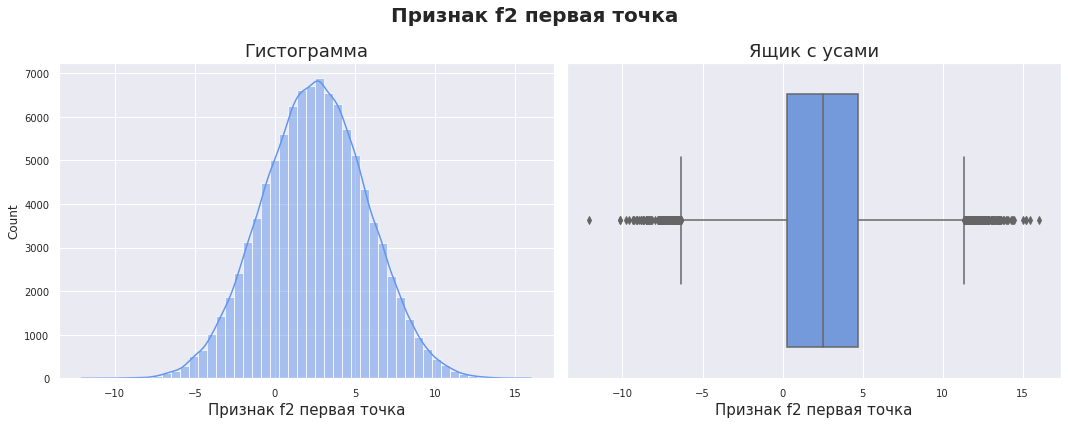

count   100000.00
mean         2.50
std          3.25
min        -12.09
25%          0.29
50%          2.52
75%          4.72
max         16.00
Name: f2, dtype: float64


In [11]:
quantitative_features(geo_0, 'f2', 'Признак f2 первая точка', bins=50)

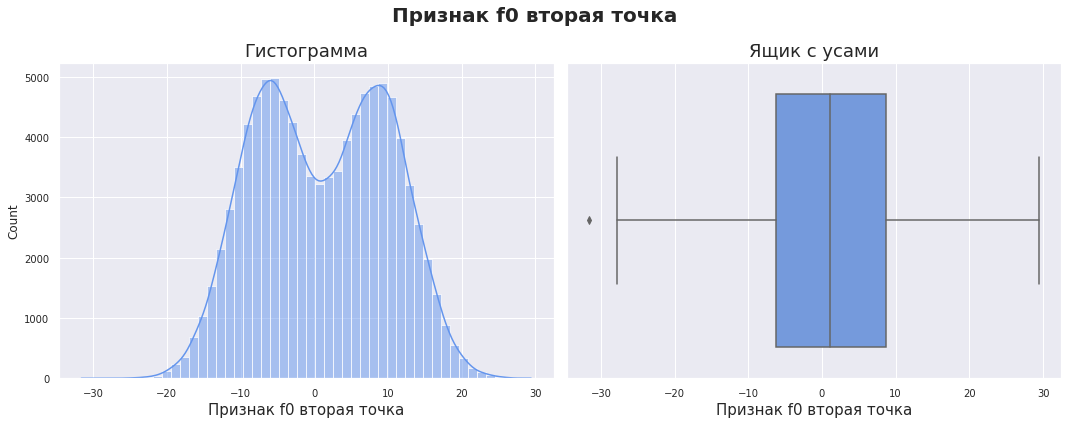

count   100000.00
mean         1.14
std          8.97
min        -31.61
25%         -6.30
50%          1.15
75%          8.62
max         29.42
Name: f0, dtype: float64


In [12]:
quantitative_features(geo_1, 'f0', 'Признак f0 вторая точка', bins=50)

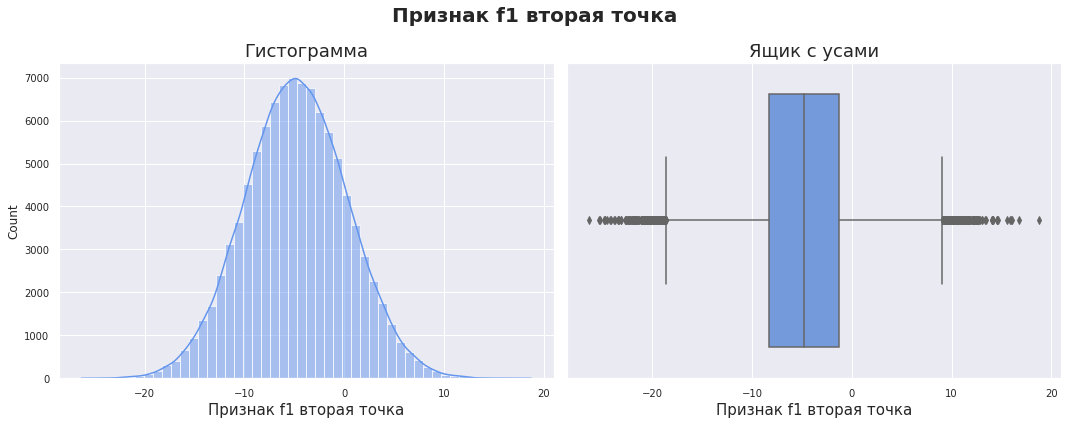

count   100000.00
mean        -4.80
std          5.12
min        -26.36
25%         -8.27
50%         -4.81
75%         -1.33
max         18.73
Name: f1, dtype: float64


In [13]:
quantitative_features(geo_1, 'f1', 'Признак f1 вторая точка', bins=50)

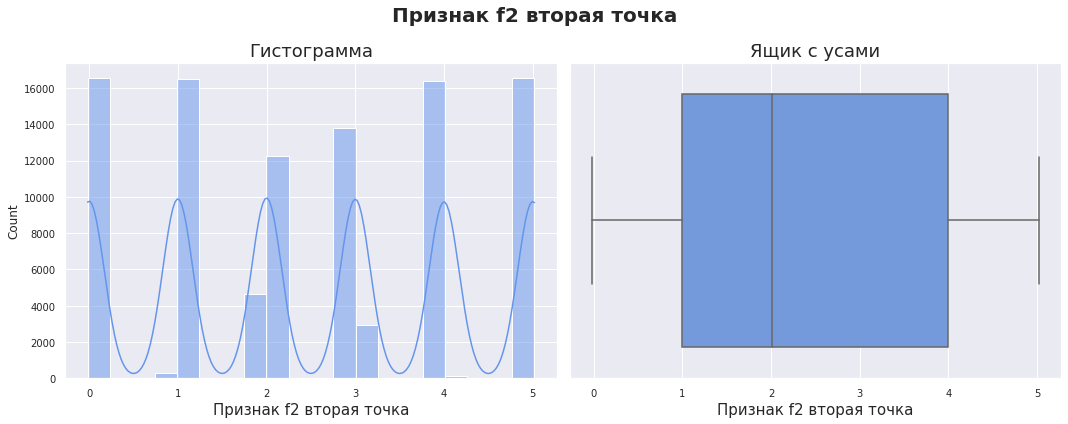

count   100000.00
mean         2.49
std          1.70
min         -0.02
25%          1.00
50%          2.01
75%          4.00
max          5.02
Name: f2, dtype: float64


In [14]:
quantitative_features(geo_1, 'f2', 'Признак f2 вторая точка', bins=20)

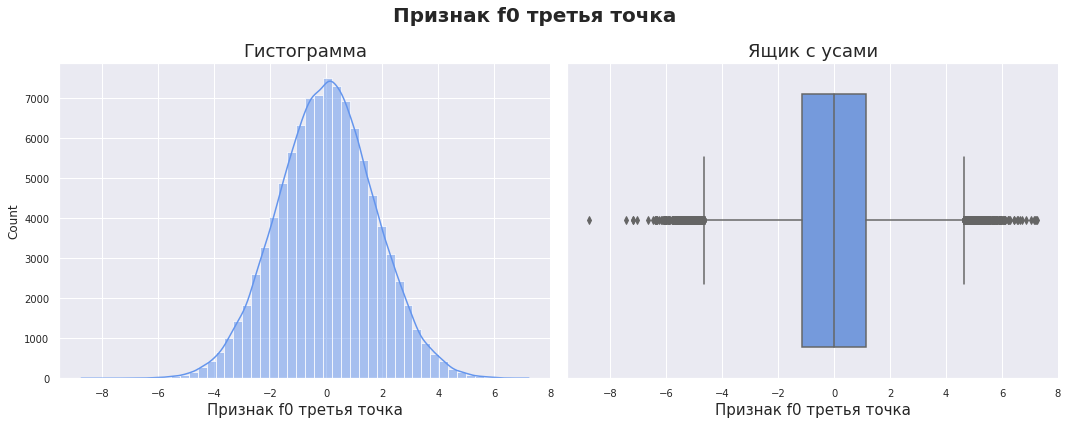

count   100000.00
mean         0.00
std          1.73
min         -8.76
25%         -1.16
50%          0.01
75%          1.16
max          7.24
Name: f0, dtype: float64


In [15]:
quantitative_features(geo_2, 'f0', 'Признак f0 третья точка', bins=50)

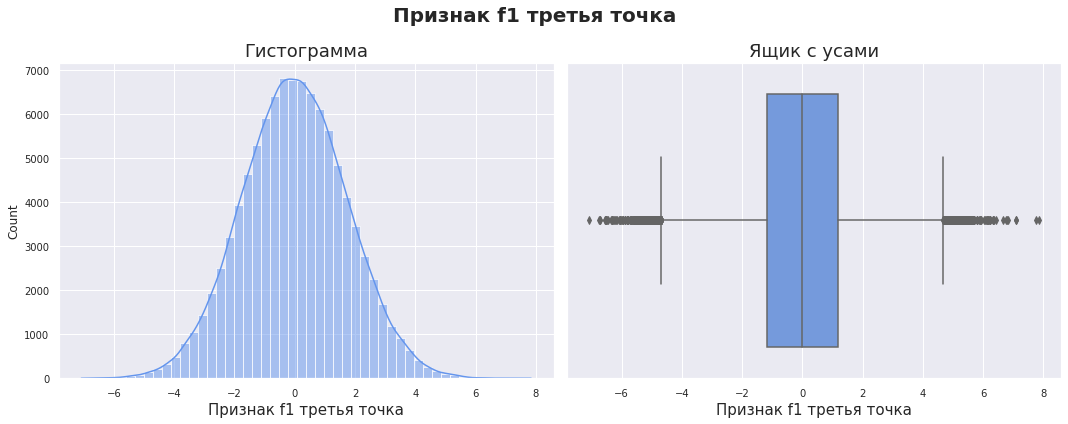

count   100000.00
mean        -0.00
std          1.73
min         -7.08
25%         -1.17
50%         -0.01
75%          1.16
max          7.84
Name: f1, dtype: float64


In [16]:
quantitative_features(geo_2, 'f1', 'Признак f1 третья точка', bins=50)

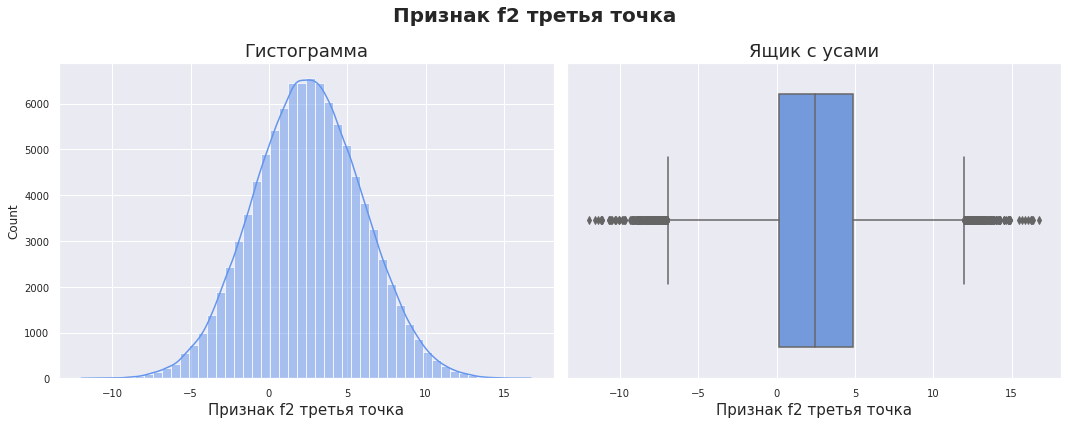

count   100000.00
mean         2.50
std          3.47
min        -11.97
25%          0.13
50%          2.48
75%          4.86
max         16.74
Name: f2, dtype: float64


In [17]:
quantitative_features(geo_2, 'f2', 'Признак f2 третья точка', bins=50)

Данные распределены нормально у всех признаков третьей точки, у признака f2 второй точки и у признака f2 первой точки. Остальные признаки распределены ненормально и имеют несколько пиков. Так же примечательно, что признаки f1, f2, f3 в каждой точке имеют различные интервалы значений. Среднее и медианное значения у всех признаков почти совпадают.

Исследуем целевой признак.

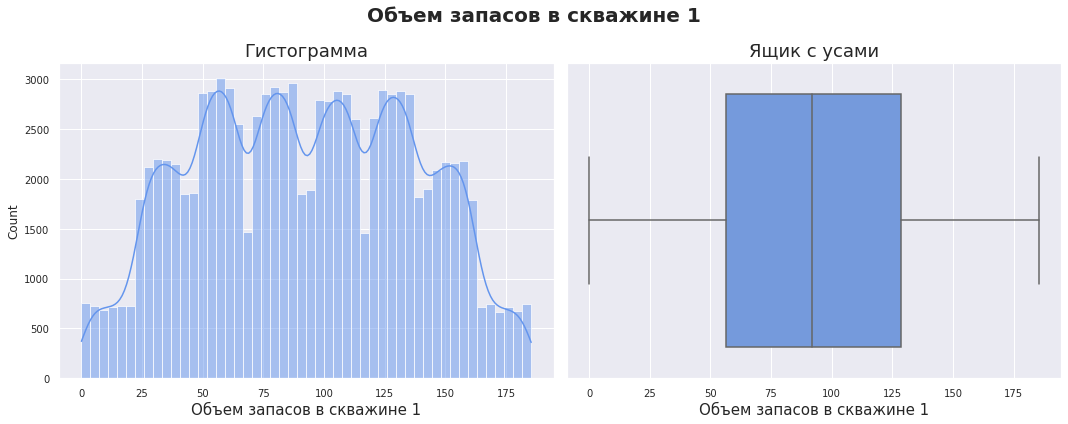

count   100000.00
mean        92.50
std         44.29
min          0.00
25%         56.50
50%         91.85
75%        128.56
max        185.36
Name: product, dtype: float64


In [18]:
quantitative_features(geo_0, 'product', 'Объем запасов в скважине 1', bins=50)

Распределение неравномерное, имеется несколько пиков, среднее и медианное значение расположены почти идентично.

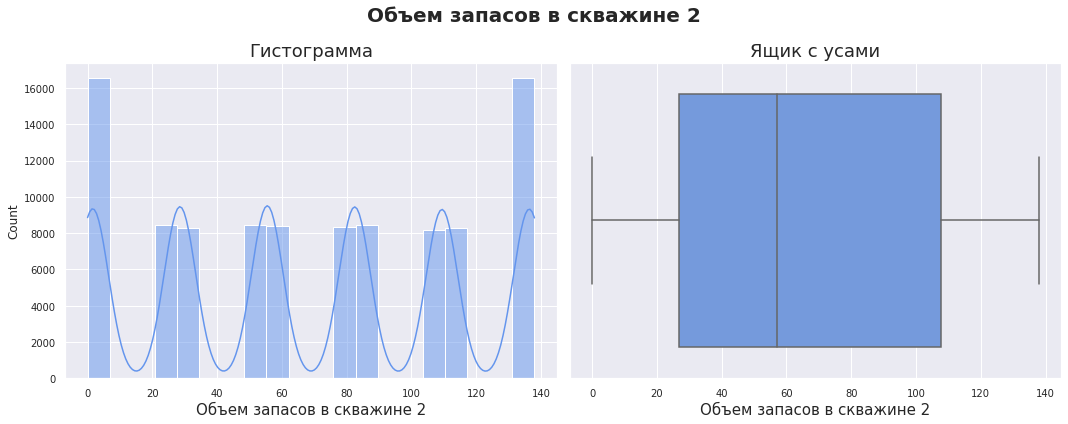

count   100000.00
mean        68.83
std         45.94
min          0.00
25%         26.95
50%         57.09
75%        107.81
max        137.95
Name: product, dtype: float64


In [19]:
quantitative_features(geo_1, 'product', 'Объем запасов в скважине 2', bins=20)

Значения имеют регулярный периодический характер, видны повторяющиеся пики распределения. Среднее и медианное значения отличаются на 10 ед. Имеется большое количество наблюдений с 0 занчением.

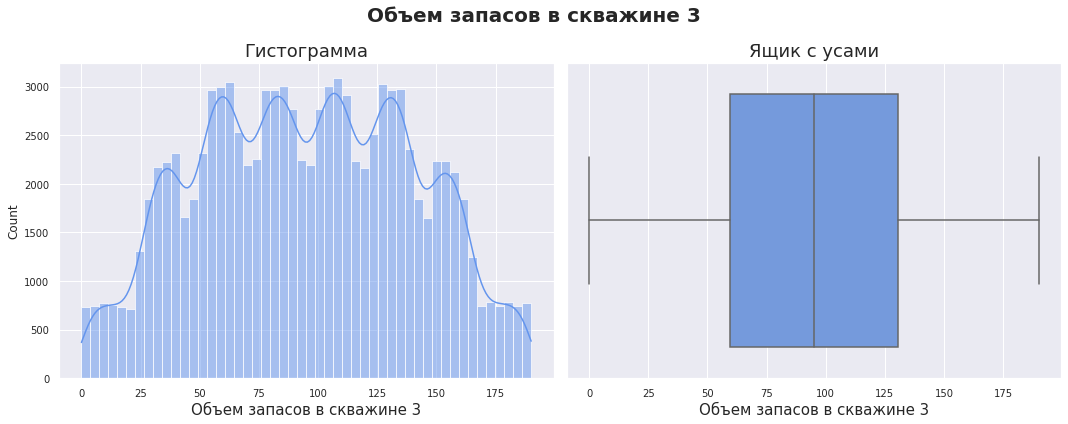

count   100000.00
mean        95.00
std         44.75
min          0.00
25%         59.45
50%         94.93
75%        130.60
max        190.03
Name: product, dtype: float64


In [20]:
quantitative_features(geo_2, 'product', 'Объем запасов в скважине 3', bins=50)

Гистограмма похожа на гистограмму целевого признака первой точки, но среднее и медианное значения выше.

Исследуем корреляцию признаков. Для этого удалим столбцы `id`.

In [21]:
geo_0 = geo_0.drop('id', axis=1)
geo_1 = geo_1.drop('id', axis=1)
geo_2 = geo_2.drop('id', axis=1)

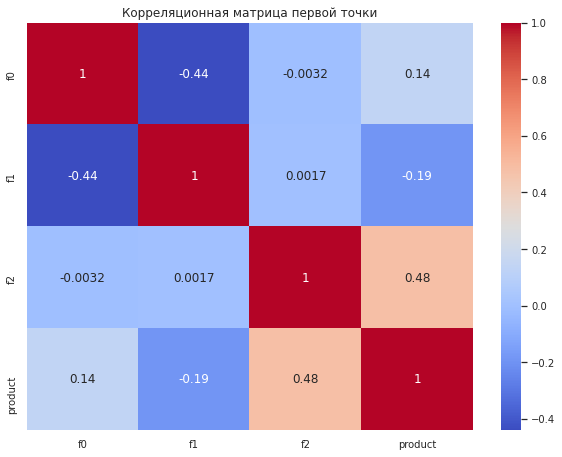

,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


In [22]:
corr_0 = geo_0.corr()
sns.heatmap(corr_0, annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица первой точки")
plt.show()

corr_0

У первой точки умеренная положительная корреляция у f2 с целевым. С оставшимися признаками слабая зависимость.

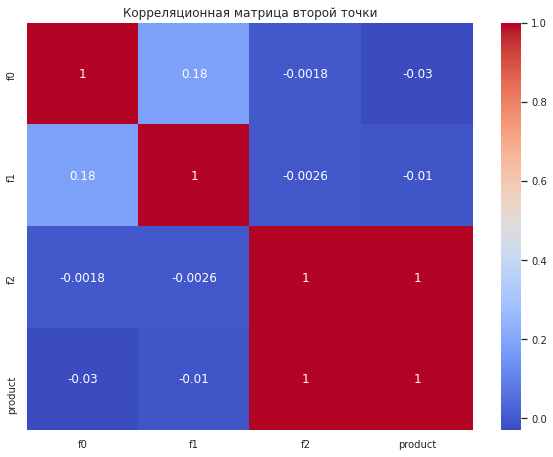

,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00


In [23]:
corr_1 = geo_1.corr()
sns.heatmap(corr_1, annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица второй точки")
plt.show()

corr_1

Наблюдается полная линейная зависимость с признаком f2. С остальными признаками связь не обнаружена.

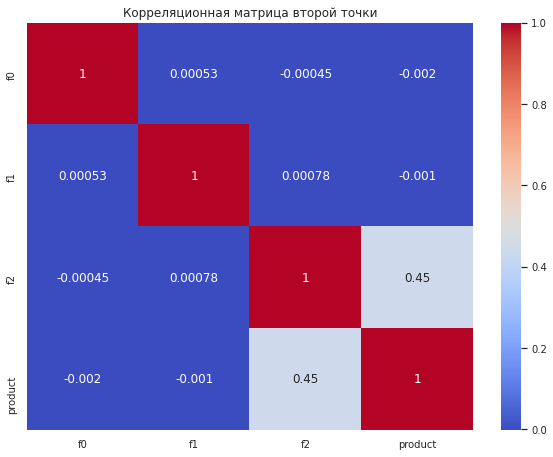

,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


In [24]:
corr_2 = geo_2.corr()
sns.heatmap(corr_2, annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица второй точки")
plt.show()

corr_2

Признаки f2 и f1 имеют сильную положительную зависимость. С целевым признаком опять же коррелирует f2, умеренно.

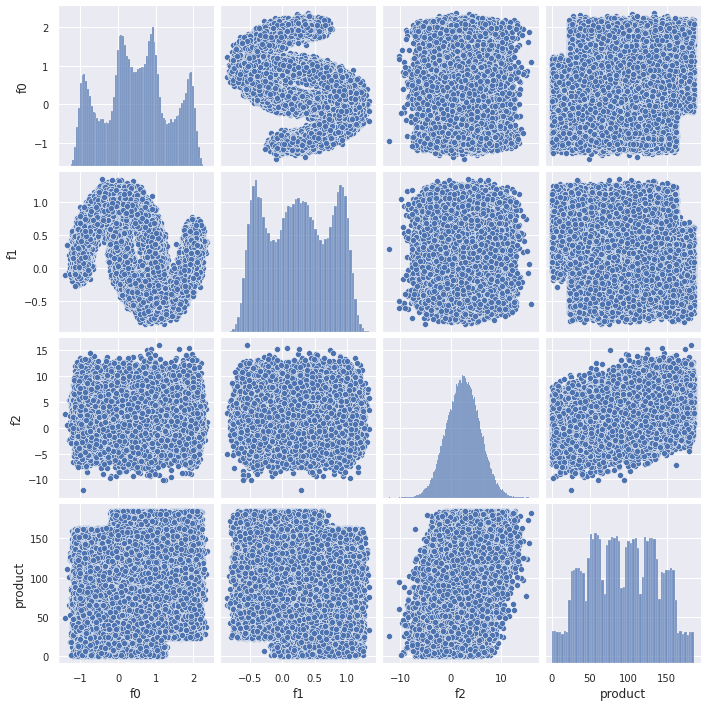

In [25]:
sns.pairplot(geo_0)
plt.show()

**Первая точка.** Между признаками f0 и f1 наблюдаются явно выраженные нелинейные зависимости в форме синусоидальных кривых. На матрице корреляции эти зависимости определяется как отрицательная умеренная линейная зависимость. 

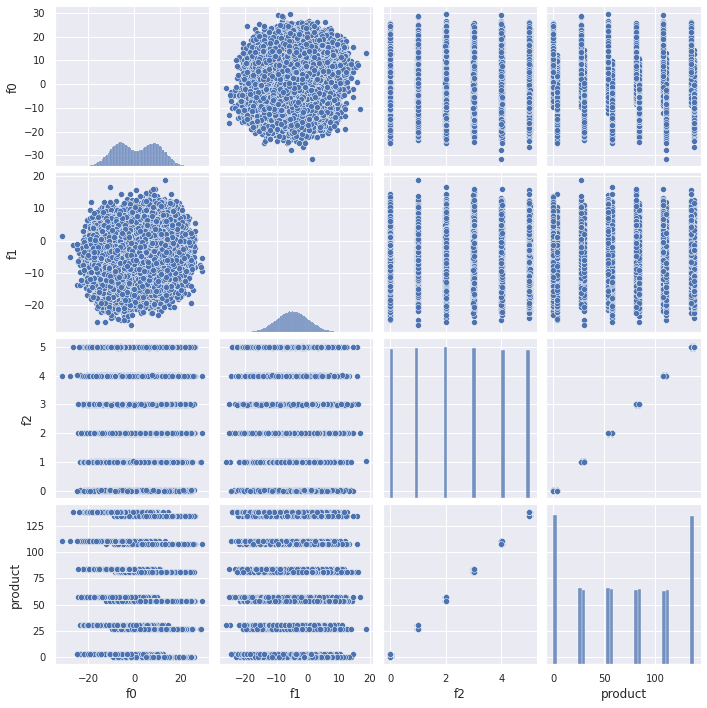

In [26]:
sns.pairplot(geo_1) 
plt.show()

**Вторая точка.** Как и наблюдалось ранее, признак f2 и целевой распределены будтобы дискретно.

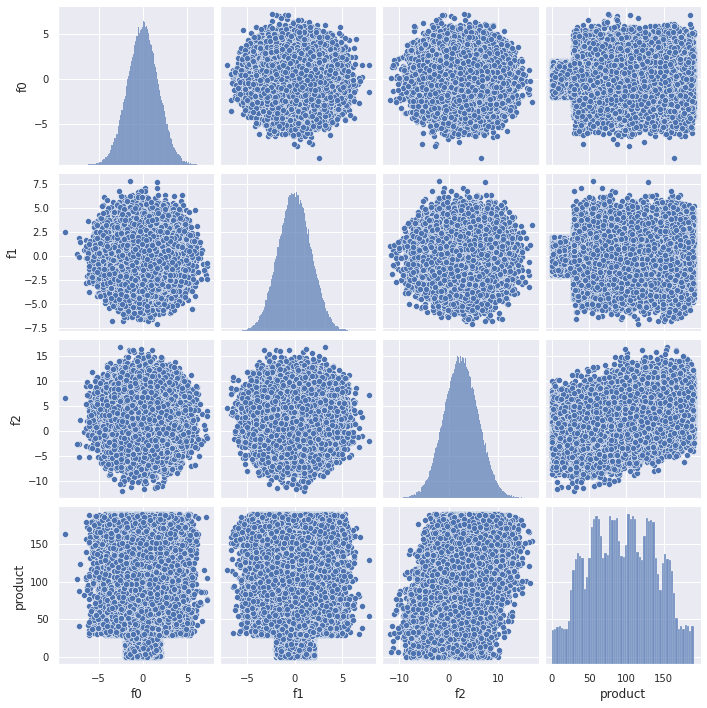

In [27]:
sns.pairplot(geo_2) 
plt.show()

**Третья точка.** Интервальные данные отсутствуют, распределения более равномерные.

#### Промежуточный вывод

**Цель:** Загрузить и подготовить данные.  
**Задачи:**
1. Загрузить данные.
2. Работа с дубликатами.
3. Исследовательский анализ.

**Результаты**

1) Загрузить данные:
- Три датафрейма `geo_0`, `geo_1`, `geo_2` содержат 100000 строк и 5 столбцов, соответсвующие типы данных, пропуски не обнаружены.

2) Работа с дубликатами:
- Явные дубликаты не обнаружены;
- Выявлены дубликаты в значениях столбцов `id`, столбцы `id` были удалены, так как не нужны для дальнейшей работы.

3) Исследовательский анализ:
- У `geo_0` распределения признаков преимущественно нормальные, но имеется нелинейная зависимость между f0 и f1. Целевой признак имеет множественные пики одного уровня, имееет умеренную положительную зависимость с f2.
- У `geo_1` распределения признаков преимущественно дискретные, интервальные, но имеется прямая линейная зависимость между f2 и целевым признаком. 
-  У `geo_2` распределения признаков равномерные. Целевой признак имеет множественные пики и имееет умеренную положительную зависимость с f2.

## Обучение и проверка модели

#### Разбивка данных и обучение модели

Обучим модель линейной регрессии.

In [28]:
names = ['geo_0', 'geo_1', 'geo_2']
data = [geo_0, geo_1, geo_2]

mean_predicted_values = []
mean_actual_values = []
rmse_values = []

targets = {}

for i in range(len(names)):
    name = names[i]
    data_item = data[i]

    target = data_item['product']
    features = data_item.drop('product', axis=1)

    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=RANDOM_STATE)
    
    model = make_pipeline(StandardScaler(), LinearRegression())
    
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index, name='pred')

    mean_predicted = predictions.mean()
    mean_actual = target_valid.mean()
    rmse = mean_squared_error(target_valid, predictions, squared=False)

    mean_predicted_values.append(mean_predicted)
    mean_actual_values.append(mean_actual)
    rmse_values.append(rmse)

    targets[name] = (target_valid, predictions)

Предсказания сохранены. 

In [29]:
for i in range(len(names)):
    name = names[i]
    target_valid, predictions = targets[name]
    
    mean_predicted = predictions.mean()
    mean_actual = target_valid.mean()
    
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    
    print(f'Регион {i + 1}: среднее предсказанное: {mean_predicted:.2f}, '
          f'среднее фактическое: {mean_actual:.2f}, RMSE: {rmse:.2f}')

Регион 1: среднее предсказанное: 92.61, среднее фактическое: 92.27, RMSE: 37.72
Регион 2: среднее предсказанное: 68.92, среднее фактическое: 68.92, RMSE: 0.89
Регион 3: среднее предсказанное: 94.80, среднее фактическое: 94.89, RMSE: 39.94


Модель лучше всего работает на данных для точки 2 (низкий RMSE и совпадение средних значений).
В точках 1 и 3 модель сталкивается с проблемами, вероятно, скорее всего из-за наличия более сложных закономерностей, которые линейная регрессия не способна уловить (такие закономерности видно на диаграмме рассеяния).

#### Промежуточный вывод

**Цель:** Обучить и проверить модель.  
**Задачи:**
1. Разбить данные.
2. Обучить модель.

**Результаты**

1) Разбить данные: 
- Все три датафрейма с данными о точках добычи были разбиты в соотношении 75:25 на тренировочную и валидационнную выбокри.
2) Обучить модель:
- Обучена модель линейной регресии, получены предсказания для валидационных выборок и сохранены в отдельный датафреймы по точкам добычи;
- Расчитано значение метрики RMSE, лучше всего модель работает на дискретных данных второй точки.
- На точках 1 и 3 значением метрики низкое, хотя различие среднего значения целевого признака маленькое.

## Подготовка к расчёту прибыли

**Условия задачи:**

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода.
* Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. 

Создадим константные переменные.

In [30]:
POINTS = 500 
BEST_OIL_WELL = 200 
BUDGET = 10000000000
BARREL_PRICE = 450000 
THRESHOLD_LOSS = 0.025

####  Расчеты 

Нужно выяснить какой объем сырья необходим для разработки новой скважины без понесения убытков. Для этого мы поделим бюджет для разработки на количество скважин, затем полученное значение поделим на доход с единицы продукта.

In [31]:
first = BUDGET / BEST_OIL_WELL
second = first/ BARREL_PRICE
print(f'Необходимый объем добычи сырья для разработки новой скважины без понесения убытков:{second}')

Необходимый объем добычи сырья для разработки новой скважины без понесения убытков:111.11111111111111


Сравним полученный объём сырья с реальным и предсказанным средним запасом в каждом регионе. 

In [32]:
data = {
    'Точка': names,
    'Среднее предсказанное': mean_predicted_values,
    'Среднее актуальное': mean_actual_values,
    'RMSE': rmse_values,
    'Вычет из необходимого (предсказанное)': [second - pred for pred in mean_predicted_values],
    'Вычет из необходимого (актуальное)': [second - actual for actual in mean_actual_values]
}

data = pd.DataFrame(data)

data

,Точка,Среднее предсказанное,Среднее актуальное,RMSE,Вычет из необходимого (предсказанное),Вычет из необходимого (актуальное)
0,geo_0,92.61,92.27,37.72,18.51,18.84
1,geo_1,68.92,68.92,0.89,42.19,42.20
2,geo_2,94.80,94.89,39.94,16.31,16.22


**Точка 1:**  
Средние предсказанные и актуальные значения очень близки (92.399 и 92.326), но большое значение RMSE (37.757) указывает на высокую вариативность предсказаний. Разница между необходимым объемом и средними значениями составляет около 18.7 тысяч баррелей. Это недостаточное значение.

**Точка 2:**
Средние предсказанные и актуальные значения практически совпадают (68.713 и 68.725). RMSE всего 0.890, что свидетельствует о высокой точности модели. Однако разница между необходимым объемом и результатами слишком велика - 42.4 тысячи баррелей, что указывает на низкую продуктивность.

**Точка 3:**  
Средние значения предсказаний (94.771) и актуальные (95.151) близки, но значительное RMSE (40.146). Разница около 16 тысяч баррелей является самой низкой, но опять таки недостаточна.

Если делать выбор по стабильности модели, то точка 2 явно лидирует благодаря низкому RMSE. Однако для безубыточной разработки новой скважины не подходит ни одна из точек.

In [33]:
def profit(target, proba, count):
    data = pd.DataFrame({target": target, "proba": proba})
    top_targets = data.sort_values("proba", ascending=False).head(count)["target"]
    return top_targets.sum() * BARREL_PRICE - BUDGET

#### Промежуточный вывод

**Цель:** Подготовка к расчету прибыли.  
**Задачи:**
1. Сохранить константные значения.
2. Найти необходимый объем добываемого сырья для безубыточной разработки.
3. Сравнить значения.
4. Написать функцию для расчета прибыли.

**Результаты**

1) Сохранить константные значения: 
- Константные значения из условий задачи сохранены в переменные;

2) Найти необходимый объем добываемого сырья для безубыточной разработки:
- Выявлено, что для безубыточной разработки скважин в точне нужно добыть не менее 111.11 тыс.баррелей.

3) Сравнить значения:
- Ни одна из представленных в данных точек не соответсвует данному значению.

4) Создание функции расчета прибыли:
- Создана функция `profit` для расчета чистой прибыли у лучших скважин.

## Расчёт прибыли и рисков 

In [34]:
state = np.random.RandomState(12345)
profits_dict = {}

for name in names:
    profits = []
    for _ in range(1000):
        target_sample = targets[name][0].sample(POINTS, replace=True, random_state=state)
        prob_sample = targets[name][1][target_sample.index]
        profits.append(profit(target_sample, prob_sample, BEST_OIL_WELL))
                       
    profits = pd.Series(profits)
    mean = profits.mean() / 1e6 
    lower = profits.quantile(0.025) / 1e6
    upper = profits.quantile(0.975) / 1e6
    risk = (profits < 0).mean()
    
    profits_dict[name] = {
        'profits': profits,
        'Средняя прибыль (млн)': mean,
        '95%-й доверительный интервал': (lower, upper),
        'Риск убытков': f'{risk * 100:.2f}%'
    }

In [35]:
for name, result in profits_dict.items():
    result_copy = result.copy()
    del result_copy['profits']
    print(f"Регион {name}: {result_copy}")

Регион geo_0: {'Средняя прибыль (млн)': 389.0434046862249, '95%-й доверительный интервал': (-92.76136370652885, 893.5398858985118), 'Риск убытков': '6.80%'}
Регион geo_1: {'Средняя прибыль (млн)': 463.1925508137267, '95%-й доверительный интервал': (73.8134471184163, 856.7398519278992), 'Риск убытков': '1.40%'}
Регион geo_2: {'Средняя прибыль (млн)': 346.48455405029057, '95%-й доверительный интервал': (-196.16263013579848, 870.3798407435777), 'Риск убытков': '10.20%'}


Итак из трех точек вероятность убытков меньше 2.5% у региона 2. Так же именно на второй точке модель предсказаний показывала наилучшее значение ключевой метрики. Так что для разработки скважин лучшим вариантом является второй регион с риском убытка равной **1.40%** и средней прибылью равной **463.19 млн.р.**.

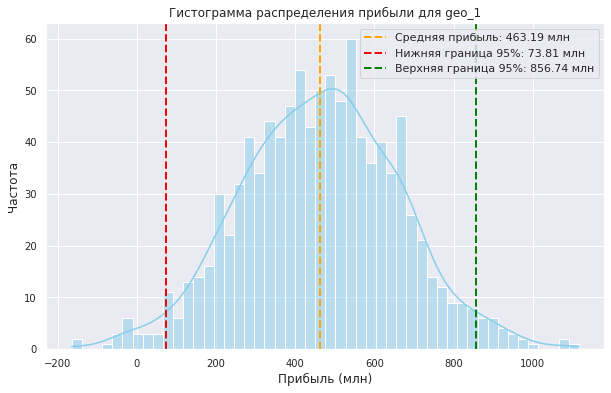

In [36]:
profits = profits_dict['geo_1']['profits']
mean_profit = profits_dict['geo_1']['Средняя прибыль (млн)']
lower_bound, upper_bound = profits_dict['geo_1']['95%-й доверительный интервал']

plt.figure(figsize=(10, 6))
sns.histplot(profits / 1e6, bins=50, kde=True, color='skyblue')
plt.axvline(mean_profit, color='orange', linestyle='dashed', linewidth=2, label=f'Средняя прибыль: {mean_profit:.2f} млн')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'Нижняя граница 95%: {lower_bound:.2f} млн')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f'Верхняя граница 95%: {upper_bound:.2f} млн')

plt.title('Гистограмма распределения прибыли для geo_1')
plt.xlabel('Прибыль (млн)')
plt.ylabel('Частота')
plt.legend()
plt.show()

# Общий вывод

Во время выполнения задачи для компании «ГлавРосГосНефть» были выполнены следующие шаги:
1) Загрузка и подготовка данных - данные были загружены, проверены на пропуски и дубликаты, был проведен исселдовательский анализ данных и изучение расспределений и зависимостей признаков.   

2) Обучение и проверка модели - данные разделили на тренировочную и валидационную выборки, обучили модель линейной регрессии со стандартны масштабированием и определена метрика RMSE; наилучшее значение метрики у региона 2 хотя средние значения целевого признака значительно уступали другим регионам.  

3) Подготовка к расчёту прибыли - созданы константные переменные, расчитано минимальное среднее значение единиц добычи для безубыточного ведения бизнеса (111.11 тыс.б.), создана функция для подсчета чистой прибыли.   

4) Расчёт прибыли и рисков - отобрали самые "продуктивные" 200 точек, посчитали прибыль и вероятность риска при помощи механизма Bootstrap, выявлено что самый низкий риск убытков (1.40%) и самая высокая средняя ожидаемая прибыль (463.19 млн.р.) у **региона 2**.